In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize

In [2]:
dataset = pd.read_csv("card_transdata.csv")

In [3]:
dataset.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [5]:
dataset.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
dataset.duplicated().sum()

0

In [7]:
dataset.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [8]:
dataset.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [9]:
dataset['fraud'].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

In [10]:
dataset['used_pin_number'].value_counts()

used_pin_number
0.0    899392
1.0    100608
Name: count, dtype: int64

In [11]:
dataset['online_order'].value_counts()

online_order
1.0    650552
0.0    349448
Name: count, dtype: int64

In [12]:
fraud_online_counts = dataset.groupby('online_order')['fraud']
fraud_online_counts.value_counts()

online_order  fraud
0.0           0.0      344756
              1.0        4692
1.0           0.0      567841
              1.0       82711
Name: count, dtype: int64

In [13]:
fraud_pin = dataset.groupby('used_pin_number')['fraud']
fraud_pin.value_counts()

used_pin_number  fraud
0.0              0.0      812262
                 1.0       87130
1.0              0.0      100335
                 1.0         273
Name: count, dtype: int64

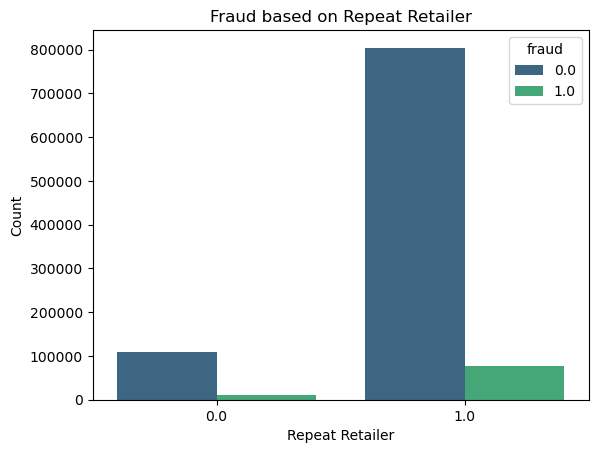

In [14]:
sns.countplot(x = 'repeat_retailer', hue = 'fraud', data = dataset, palette='viridis')
plt.title("Fraud based on Repeat Retailer")
plt.xlabel("Repeat Retailer")
plt.ylabel("Count")
plt.show()

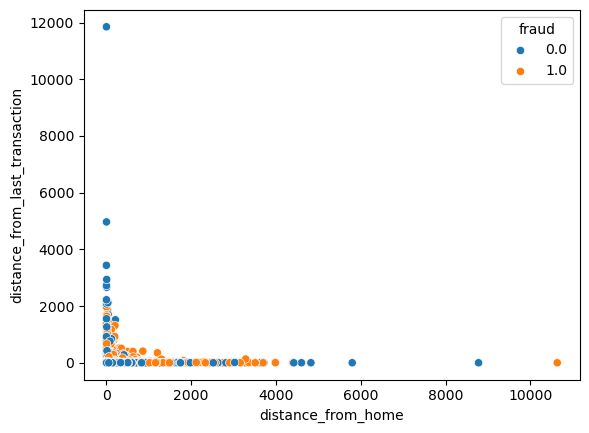

In [15]:
sns.scatterplot(x='distance_from_home', y='distance_from_last_transaction', hue='fraud', data=dataset)
plt.show()

In [16]:
class MLDataPipeline:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.logs = []

    def log(self, message):
        """Log messages for better traceability"""
        self.logs.append(message)
        print(message)
        
    def load_data(self, file_path = None, dataset=None):
        """ Load Data From various formats """
        if file_path:
            ext = os.path.splitext(file_path)[-1].lower()
            if ext == '.csv':
                dataset = pd.read_csv(file_path)
            elif ext in ['.xls', '.xlsx']:
                dataset = pd.read_excel(file_path)
            elif ext == '.json':
                dataset = pd.read_json(file_path)
            else:
                raise ValueError("Unsupported File Format. Please Use CSV or Excel or JSON file for Importing")
            self.log("Data Loaded successfully from " + file_path)
        elif dataset is not None:
            dataset = dataset
            self.log("Data Loaded from provided dataset")
        else:
            raise ValueError("Either file_path or dataset must be provided")
        return dataset
        
    def data_summary(self, dataset):
        """ Basic Info and Insights from Dataset """
        self.log("Data Summary")
        print(dataset.info())
        self.log("Missing Values:\n")
        print(dataset.isnull().sum())
        print(dataset.isna().sum())
        print(dataset.dropna())
        self.log("Duplicate Rows:\n")
        print(dataset.duplicated().sum())
        self.log("Data Types:\n")
        print(dataset.dtypes)
        print(dataset.head())
        return dataset

    def detect_binary_columns(self, dataset):
        binary_columns = [col for col in dataset.columns if dataset[col].nunique() == 2 and set(dataset[col].unique()) == {0,1}]
        self.log(f"Detected Binary columns in the dataset: {binary_columns}")
        return binary_columns

    def handle_duplicates(self, dataset):
        duplicates = dataset.duplicated().sum()
        if duplicates > 0:
            dataset = dataset.drop_duplicates()
            self.log("Removed Duplicate rows")
        else:
            self.log("No Duplicate rows found")
        return dataset
        
    def handle_missing_values(self, dataset):
        """ Fill missing values for numerical and categorical columns """
        self.log("Handling Missing Values..")
        binary_columns = self.detect_binary_columns(dataset)
        dataset = dataset.dropna(axis = 1, how = "all")
        for col in dataset.select_dtypes(include = ['object']).columns:
                dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
        for col in dataset.select_dtypes(include = ['float64', 'int64']).columns:
            if col not in binary_columns:
                imputer = KNNImputer(n_neighbors=5)
                dataset[col] = imputer.fit_transform(dataset[col].values.reshape(-1, 1))
        self.log("Missing values handled successfully")
        return dataset

    def detect_outliers(self, dataset):
        self.log("Detecting and removing outliers...")
        binary_columns = self.detect_binary_columns(dataset)
        numerical_columns_b = [col for col in dataset.select_dtypes(include=['float64', 'int64']).columns if col not in binary_columns]
        for col in numerical_columns_b:
            #dataset[col] = winsorize(dataset[col], limits=[0.05, 0.05])
            q1, q3 = np.percentile(dataset[col].fillna(dataset[col].median()), [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)
            dataset[col] = np.clip(dataset[col], lower_bound, upper_bound)
            self.log(f"Outliers capped from {col}")
        return dataset
        
    def check_skewness(self, dataset):
        """ Identifying skewness in numerical columns """
        numerical_columns = dataset.select_dtypes(include = ['float64', "int64"]).columns
        binary_columns = self.detect_binary_columns(dataset)
        skewed_columns = {}
        for col in numerical_columns:
            if col not in binary_columns:
                skewness = stats.skew(dataset[col])
                if abs(skewness) > 0.60:
                    skewed_columns[col] = skewness
        print("Highly skewed columns", skewed_columns)
        return skewed_columns
        
    def correct_skewness(self, dataset):
        """ Applying Quantile Transformation for Highly Skewed Columns """
        skewed_columns = self.check_skewness(dataset)
        qt = QuantileTransformer(n_quantiles = 500, output_distribution = "normal")
        for col in skewed_columns:
                #dataset[col] = qt.fit_transform(dataset[col].values.reshape(-1,1))
                dataset[col] = np.log1p(dataset[col])
        self.log("Skewness corrected using Quantile Transformer into Normal Continuous Distribution for Highly Skewed Columns")
        return dataset

    def plot_skewness(self, dataset):
        """Visualizing Skewness Distribution with Histogram"""
        binary_columns = self.detect_binary_columns(dataset)  # Ensure this is called correctly
        numerical_columns = [col for col in dataset.select_dtypes(include=['float64', 'int64']).columns if col not in binary_columns]
        if not numerical_columns:
            self.log("No numerical columns to plot skewness.")
            return dataset
        n_cols = 5
        n_rows = (len(numerical_columns) + n_cols - 1) // n_cols
        plt.figure(figsize=(15, 8))
        for i, col in enumerate(numerical_columns, 1):
            plt.subplot(4, 5, i)
            sns.histplot(dataset[col], kde=True)
            plt.title(f"Skewness for {col}: {stats.skew(dataset[col]):.2f}")
        plt.tight_layout()
        plt.show()
        return dataset
    

    def run_pipeline(self, file_path=None, dataset=None):
        """ End-to-End Pipeline """
        dataset = self.load_data(file_path = file_path, dataset = dataset)
        dataset = self.data_summary(dataset)
        binary_columns = self.detect_binary_columns(dataset)
        dataset = self.handle_duplicates(dataset) 
        dataset = self.handle_missing_values(dataset)
        dataset = self.detect_outliers(dataset)
        skewed_columns = self.check_skewness(dataset)
        dataset = self.correct_skewness(dataset)
        dataset = self.plot_skewness(dataset)
        return dataset


Data Loaded from provided dataset
Data Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB
None
Missing Values:

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_

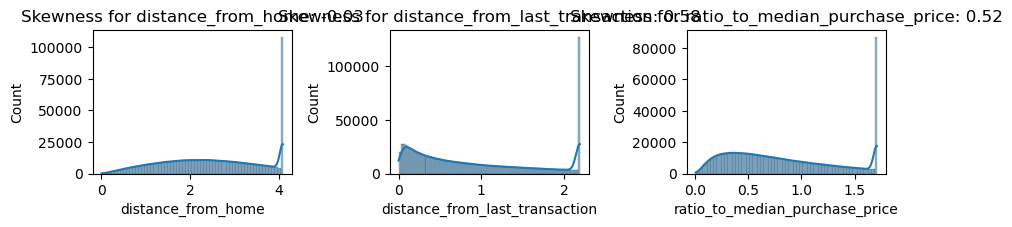

In [17]:
pipeline = MLDataPipeline()
cleaned_credit_data = pipeline.run_pipeline(dataset=dataset)

In [18]:
cleaned_credit_data.to_csv("cleaned_credit_data.csv", index = False)

In [19]:
cleaned_credit_data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,4.075465,0.270897,1.080428,1.0,1.0,0.0,0.0,0.0
1,2.470634,0.161771,0.830392,1.0,0.0,0.0,0.0,0.0
2,1.806825,0.590645,0.356075,1.0,0.0,0.0,1.0,0.0
3,1.177905,1.887076,0.309441,1.0,1.0,0.0,1.0,0.0
4,3.810897,0.448835,1.170240,1.0,1.0,0.0,1.0,0.0


In [20]:
class ExploratoryDataAnalysis:
    def __init__(self):
        self.logs = []
        
    def log(self, message):
        self.logs.append(message)
        print(message)

    def load_data(self, file_path):
        return MLDataPipeline().load_data(file_path)

    def visualize_correlation(self, dataset):
        self.log("Correlation Matrix")
        numerical_data = dataset.select_dtypes(include=["float64", "int64"])
        corr_matrix = numerical_data.corr()
        print(corr_matrix)
        plt.figure(figsize = (10,8))
        sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = '.2f', linewidths = 0.5)
        plt.title("Correlation Matrix")
        plt.show()
        
    def visualize_feature_distributions(self, dataset):
        self.log("Visualizing distributions of Numerical features")
        numerical_columns = dataset.select_dtypes(include = ["float64", "int64"]).columns
        plt.figure(figsize = (15, 10))
        for i, col in enumerate(numerical_columns, 1):
            if col in numerical_columns:
                plt.subplot(5,5,i)
                sns.histplot(dataset[col], kde = True, color = "blue")
                plt.title("Distribution of" + col)
        plt.tight_layout()
        plt.show()
        
    def visualize_boxplots(self, dataset):
        self.log("Visualizing boxplots for outlier detection")
        numerical_columns = dataset.select_dtypes(include = ["float64", "int64"]).columns
        plt.figure(figsize = (15, 10))
        for i, col in enumerate(numerical_columns, 1):
            plt.subplot(5,5,i)
            sns.boxplot(x = dataset[col], color = "green")
            plt.title("Boxplot of" + col)
        plt.tight_layout()
        plt.show()

    def plot_bivariate_analysis(self, dataset):
        self.log("Visualizing Bi-Variate Analysis")
        numerical_columns = dataset.select_dtypes(include = ["float64", "int64"]).columns
        for i in range(len(numerical_columns)):
            for j in range(i+1, len(numerical_columns)):
                plt.figure(figsize = (8, 6))
                sns.scatterplot(data = dataset, x = numerical_columns[i], y = numerical_columns[j])
                plt.title(f" {numerical_columns[i]} vs {numerical_columns[j]}")
                plt.show()
        return dataset         
        
    def run_eda(self, file_path):
        self.log("Running EDA Pipeline")
        dataset = self.load_data(file_path)
        self.visualize_correlation(dataset)
        self.visualize_feature_distributions(dataset)
        self.visualize_boxplots(dataset)
        self.plot_bivariate_analysis(dataset)
        self.log("EDA Pipeline completed successfully")

        

Running EDA Pipeline
Data Loaded successfully from cleaned_credit_data.csv
Correlation Matrix
                                distance_from_home  \
distance_from_home                        1.000000   
distance_from_last_transaction           -0.000963   
ratio_to_median_purchase_price           -0.000035   
repeat_retailer                           0.586571   
used_chip                                -0.000157   
used_pin_number                          -0.000341   
online_order                             -0.001905   
fraud                                     0.088557   

                                distance_from_last_transaction  \
distance_from_home                                   -0.000963   
distance_from_last_transaction                        1.000000   
ratio_to_median_purchase_price                       -0.000684   
repeat_retailer                                      -0.000686   
used_chip                                            -0.000316   
used_pin_number        

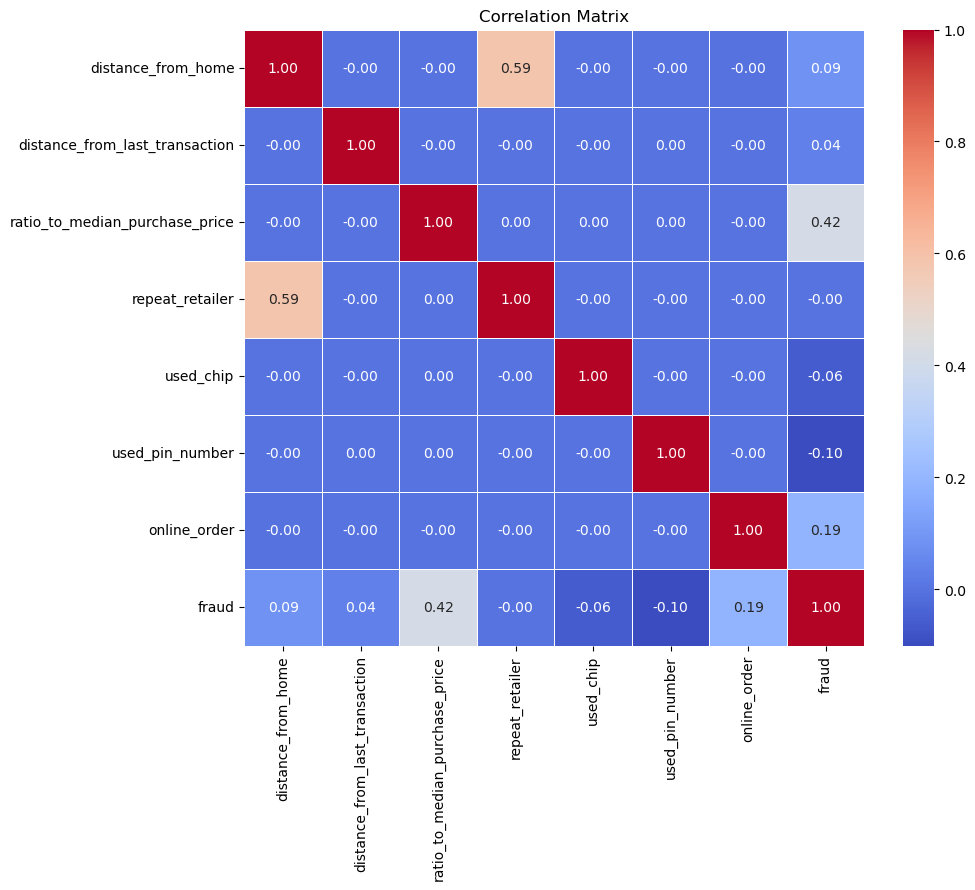

Visualizing distributions of Numerical features


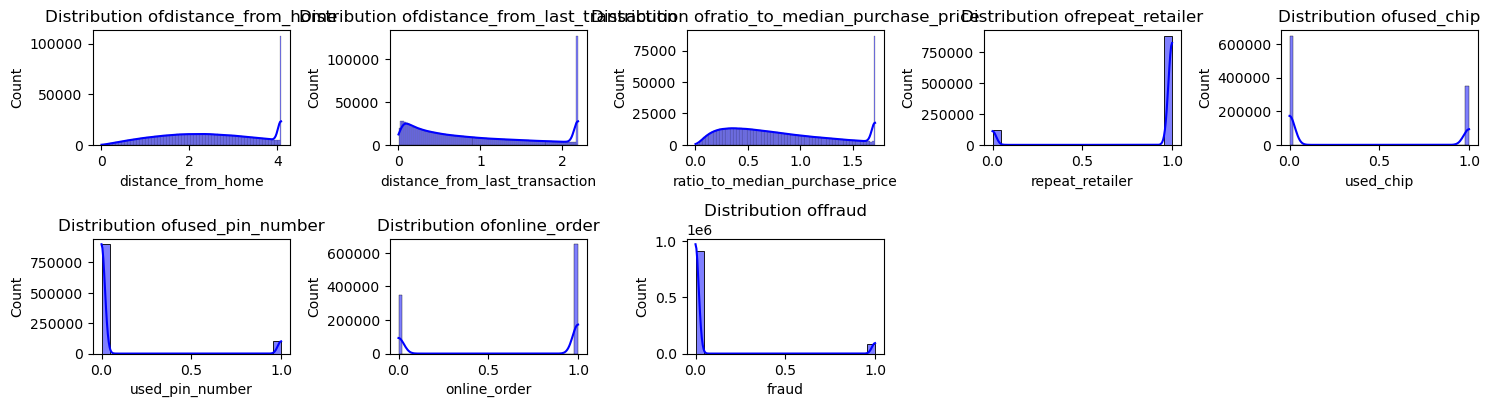

Visualizing boxplots for outlier detection


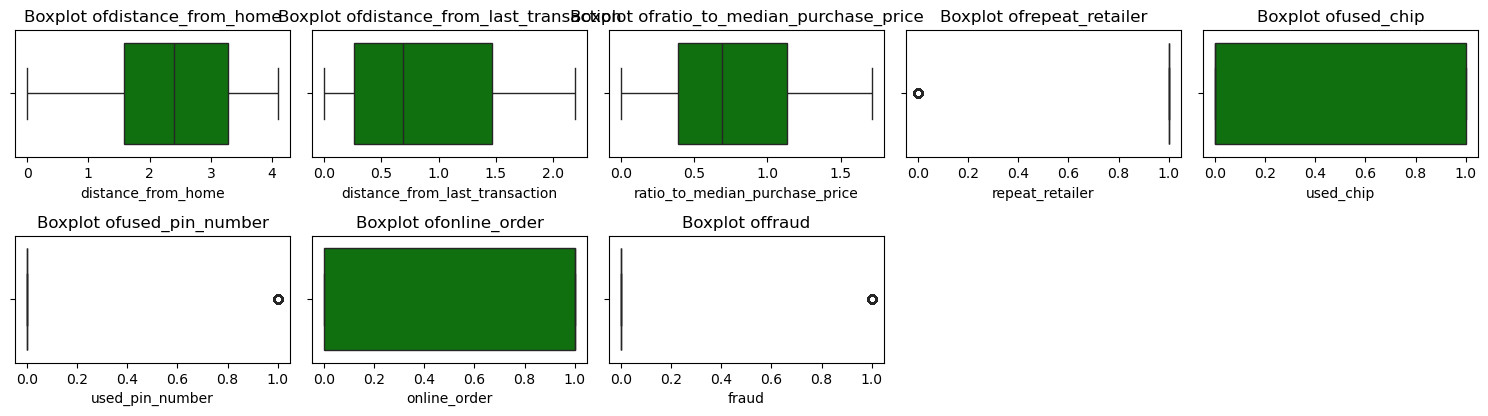

Visualizing Bi-Variate Analysis


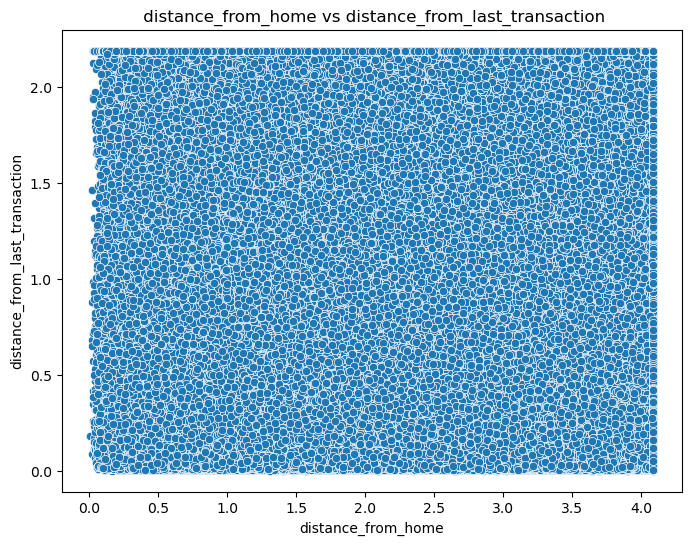

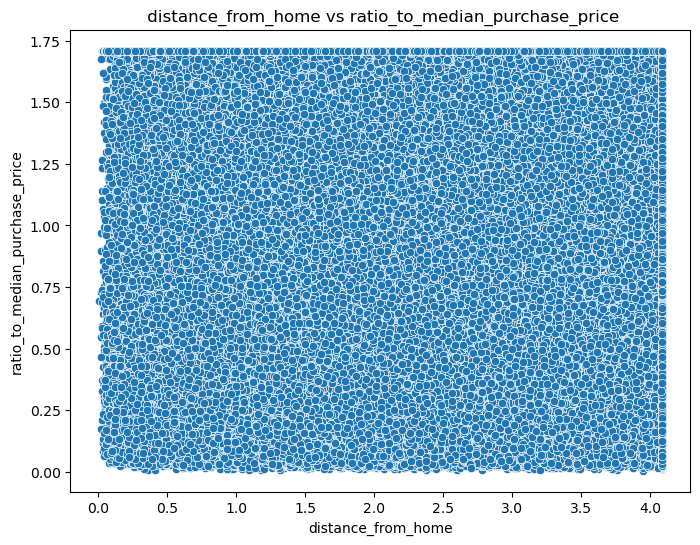

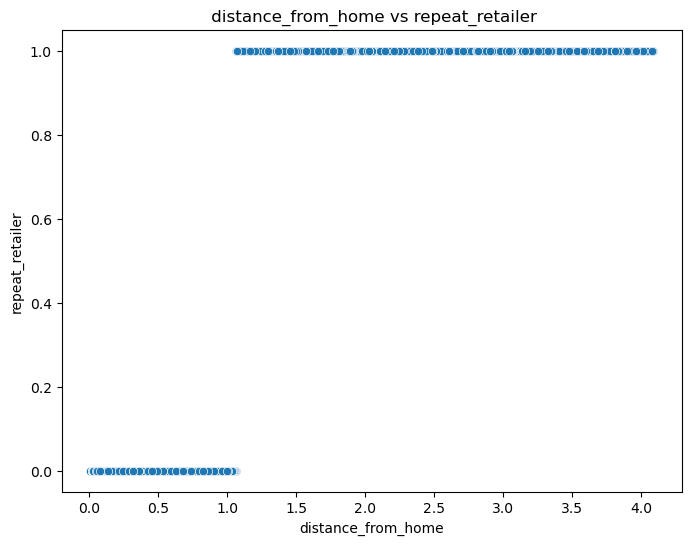

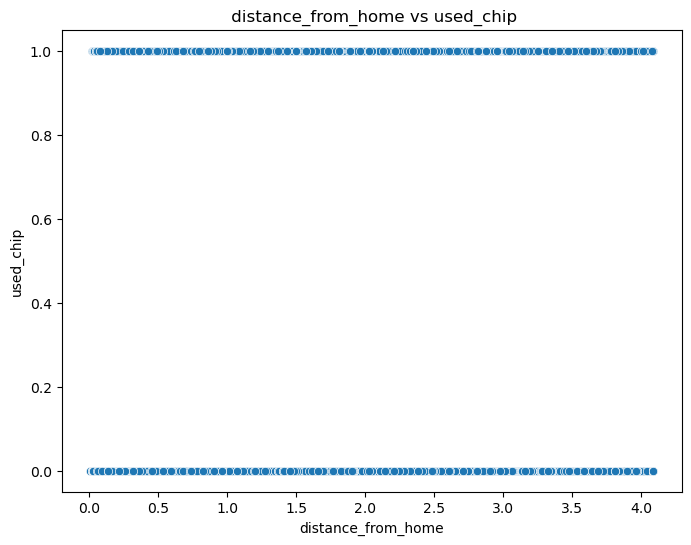

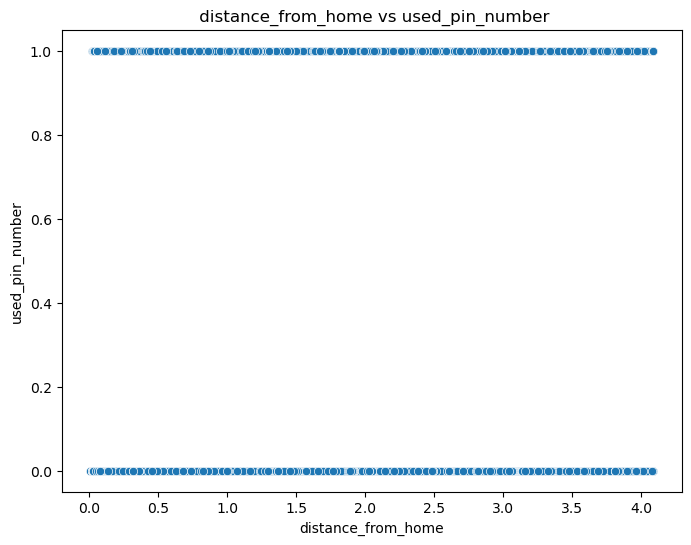

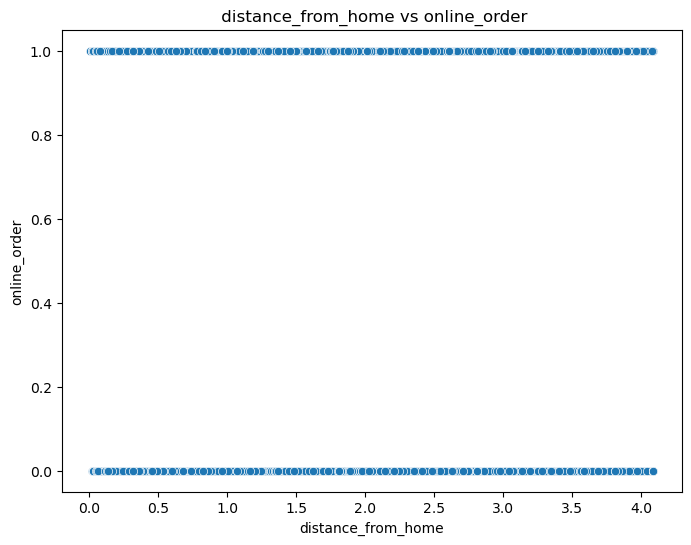

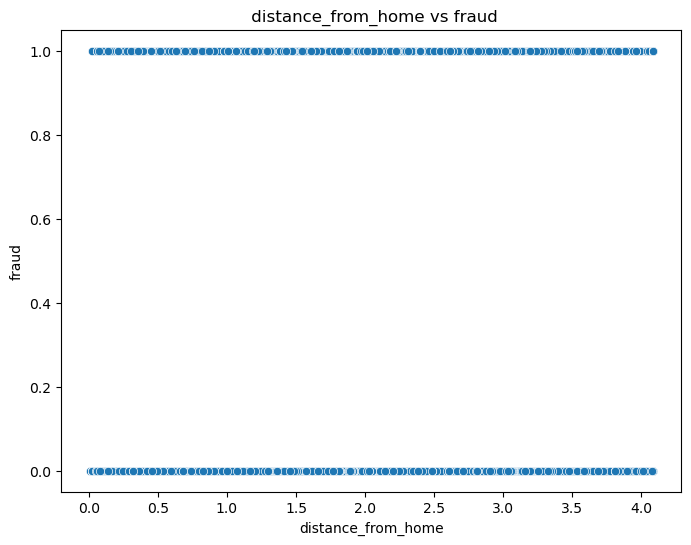

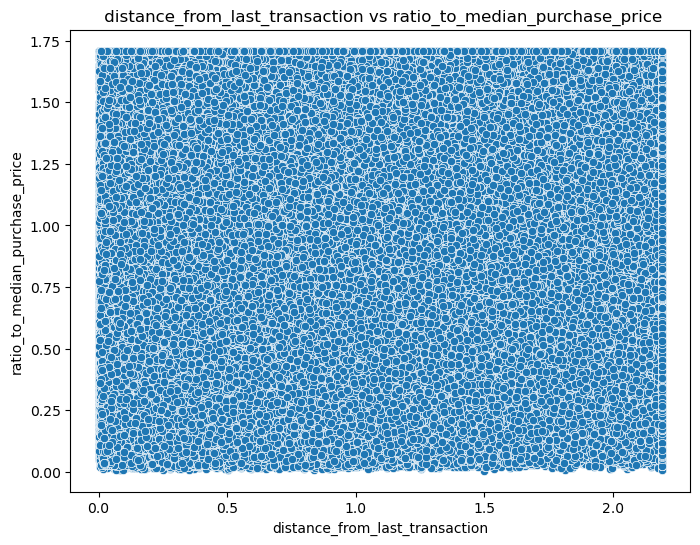

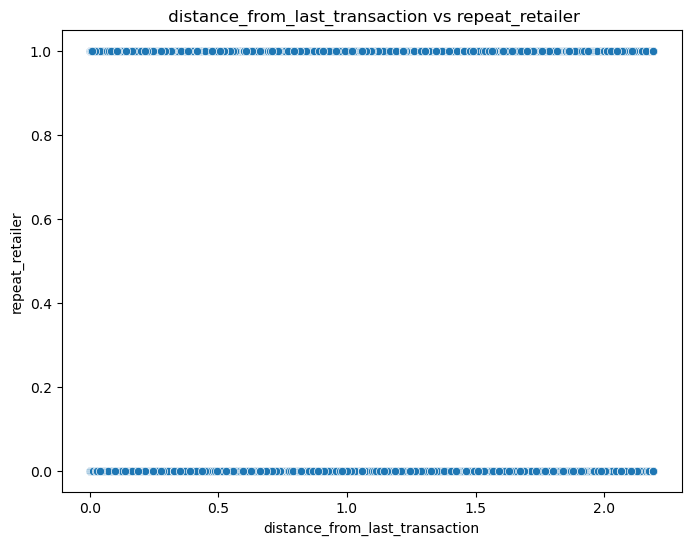

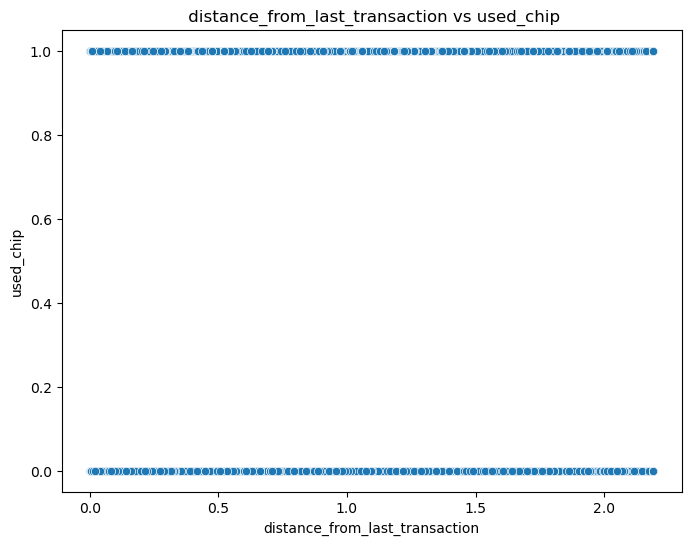

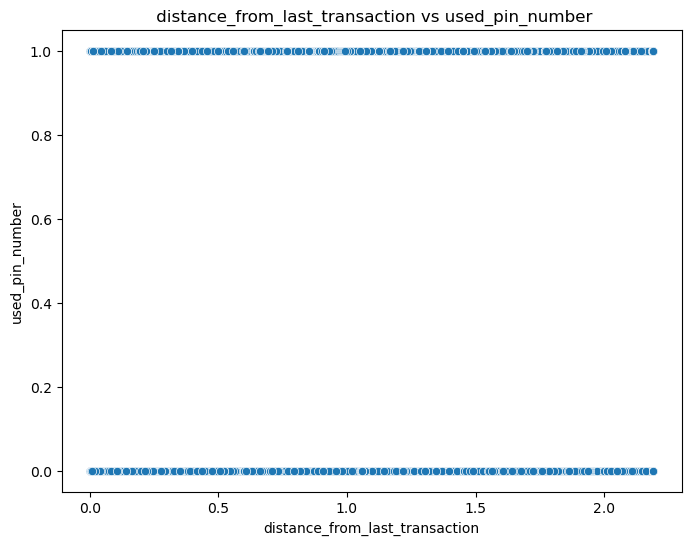

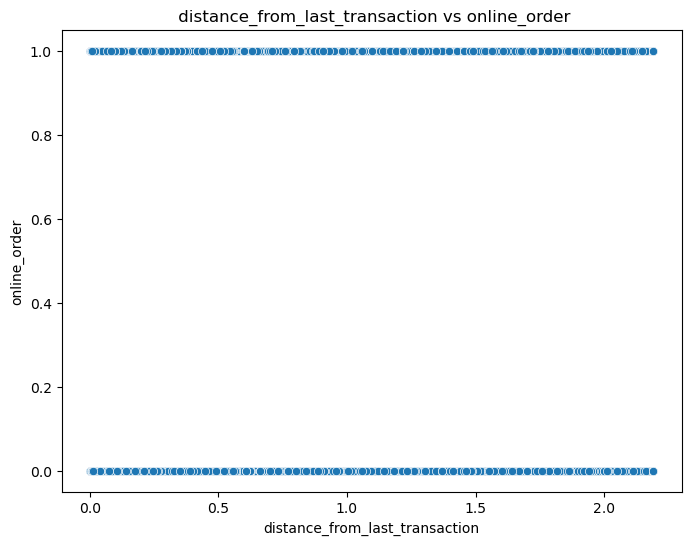

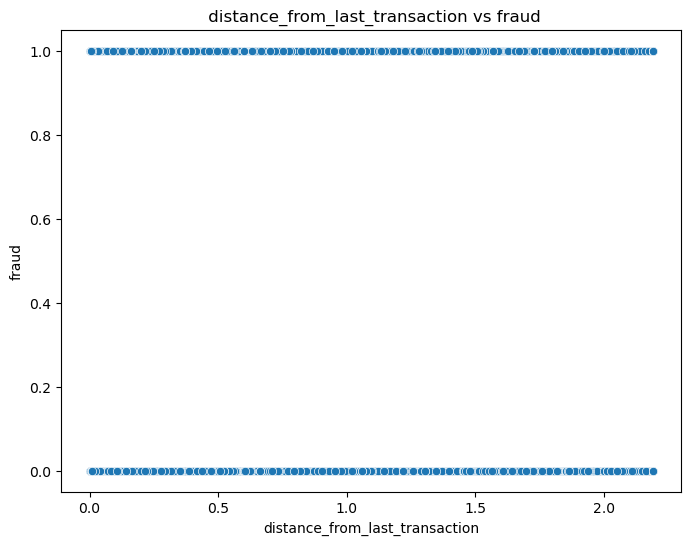

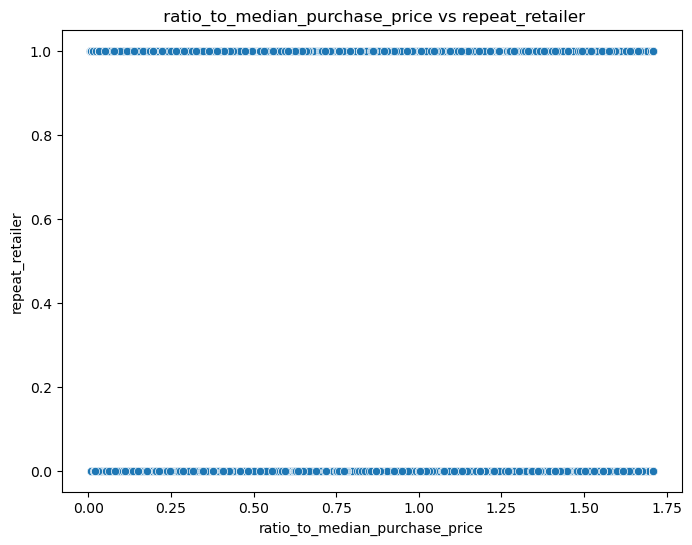

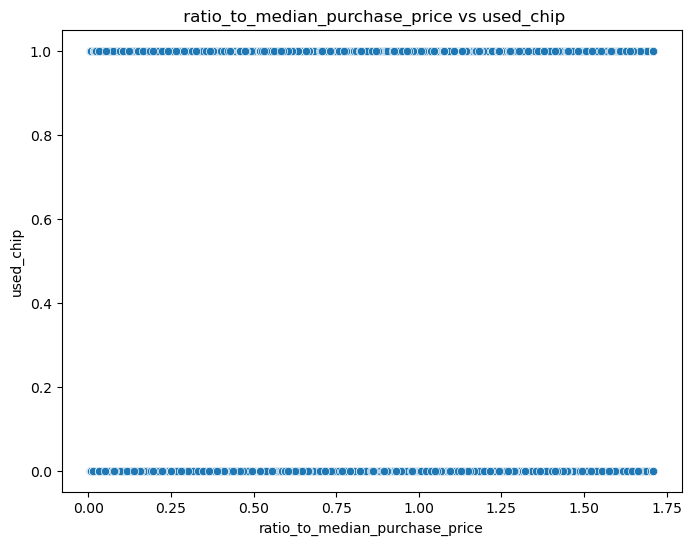

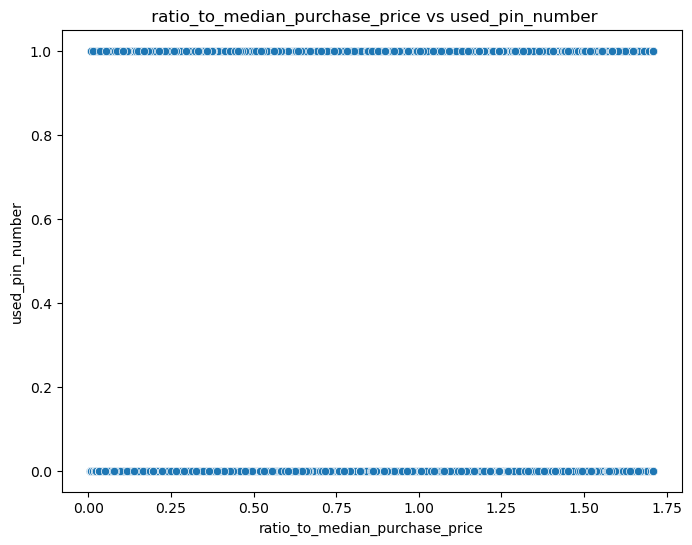

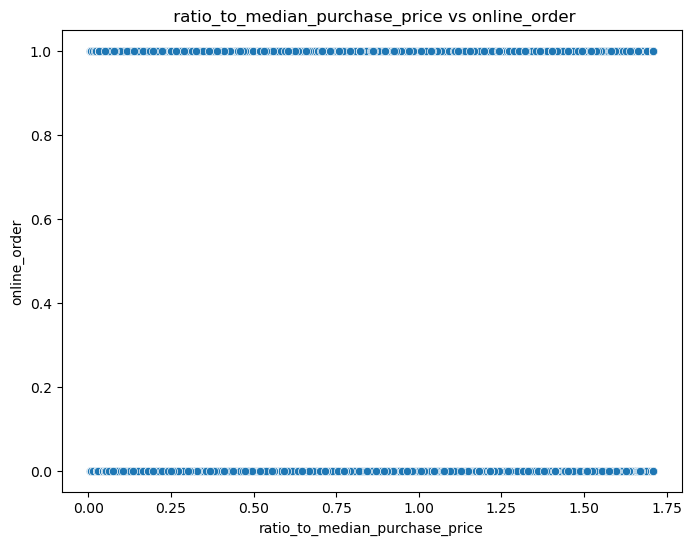

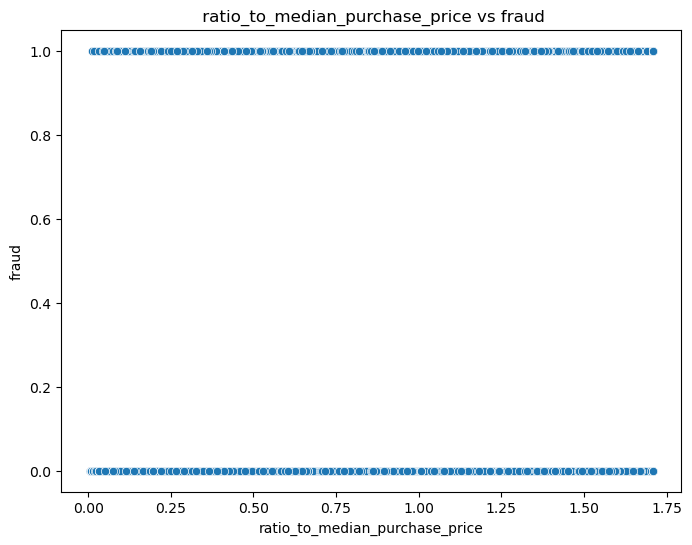

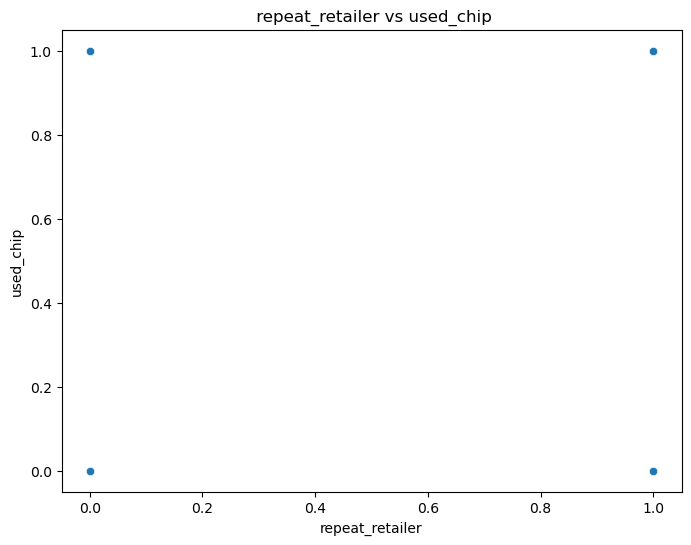

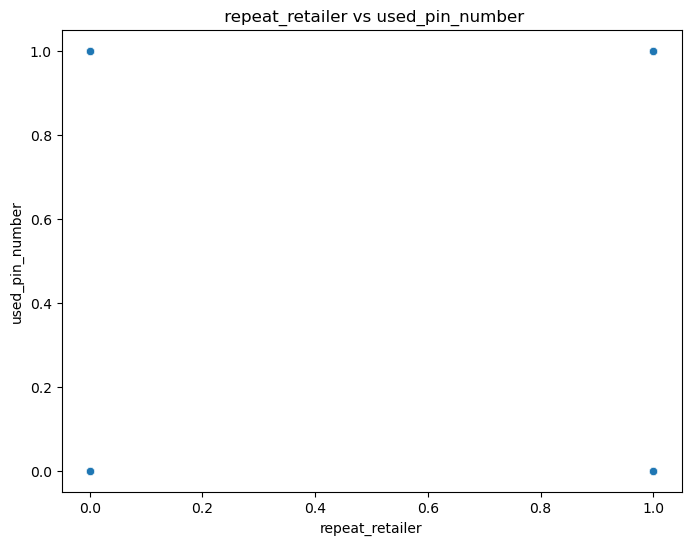

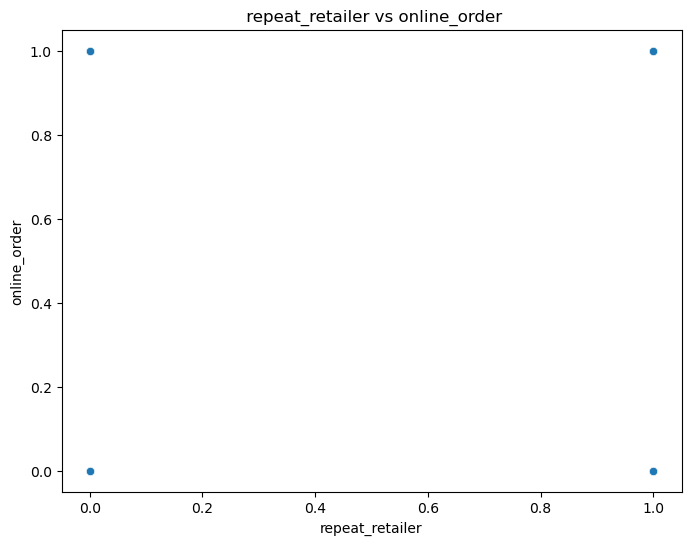

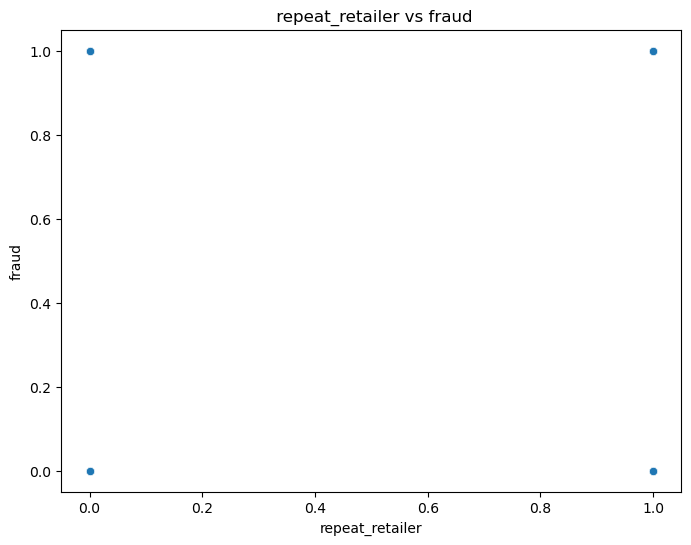

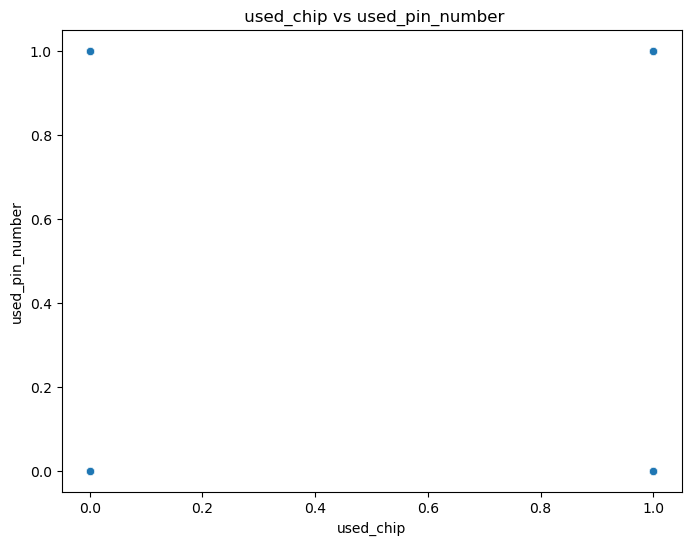

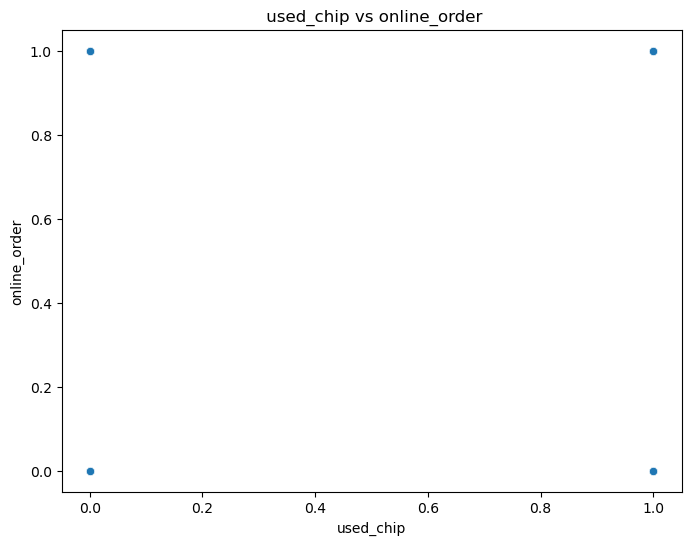

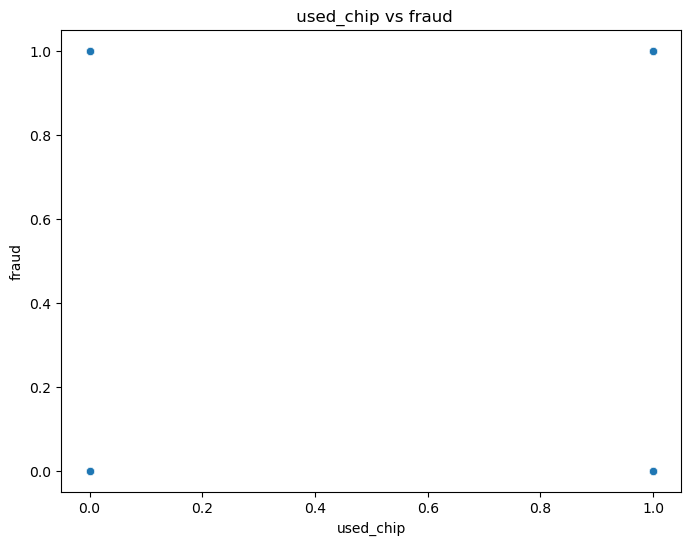

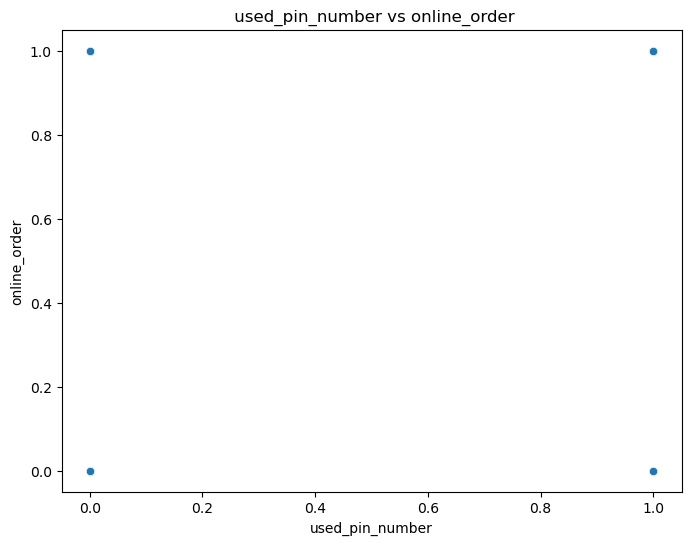

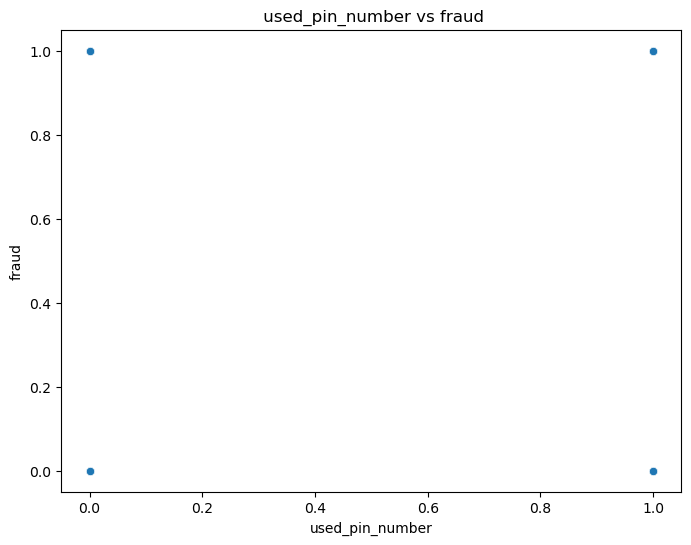

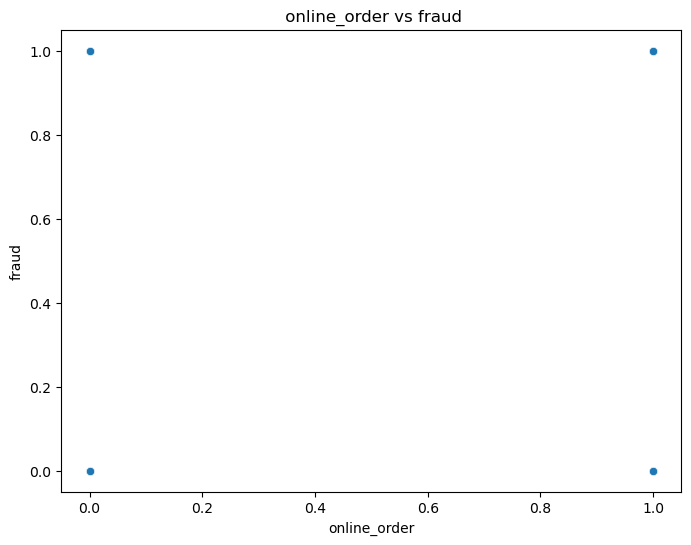

EDA Pipeline completed successfully


In [21]:
eda = ExploratoryDataAnalysis()
file_path = 'cleaned_credit_data.csv'
eda.run_eda(file_path)

### Univariate Analysis

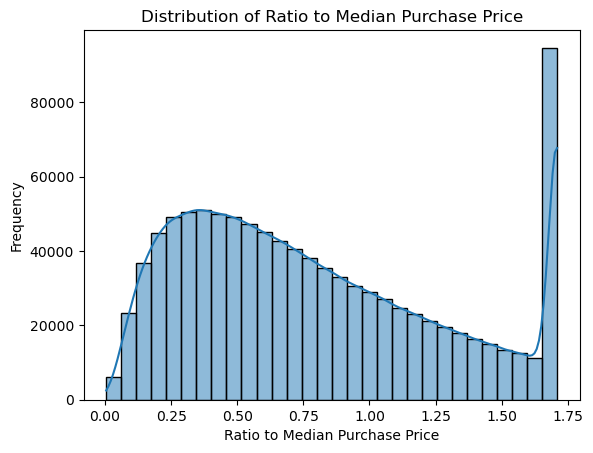

In [22]:
sns.histplot(cleaned_credit_data['ratio_to_median_purchase_price'], kde=True, bins=30)
plt.title('Distribution of Ratio to Median Purchase Price')
plt.xlabel('Ratio to Median Purchase Price')
plt.ylabel('Frequency')
plt.show()

In [23]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import joblib
import shap
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import pandas as pd

## Model Building Pipeline

In [24]:
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
import joblib
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd

class ModelPipeline:
    def __init__(self):
        self.logs = []
        self.label_encoders = {}
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.best_metrics = None

    def log(self, message):
        self.logs.append(message)
        print(message)

    def load_data(self, file_path):
        return MLDataPipeline().load_data(file_path)

    def split_data(self, dataset, target_column):
        self.log("Splitting data into train and test sets")
        X = dataset.drop(columns=[target_column])
        y = dataset[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        print("Train Size:", X_train.shape)
        print("Test Size:", X_test.shape)
        self.log("Data splitting completed")
        return X_train, X_test, y_train, y_test

    def feature_selection(self, X_train, y_train, X_test, top_n=15):
        self.log("Applying feature selection")
        X_train.columns = X_train.columns.astype(str)
        X_test.columns = X_test.columns.astype(str)
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        print("Feature Importance using Random Forest:\n", feature_importance)
        best_features = feature_importance.iloc[:top_n]['Feature'].tolist()
        X_train = X_train[best_features]
        X_test = X_test[best_features]
        return X_train, X_test, best_features

    def standardization(self, X_train, X_test):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        self.log("Standardization Completed")
        return X_train, X_test

    def handle_class_imbalance(self, X_train, y_train, threshold=0.2, method=None):
        self.log("Balancing data using ADASYN/SMOTE or undersampling based on the imbalance ratio of dataset")
        class_counts = y_train.value_counts()
        imbalance_ratio = class_counts.min() / class_counts.max()
        print("Imbalance Ratio:", imbalance_ratio)
        if not method:
            method = 'adasyn' if imbalance_ratio < threshold else 'undersampling'
        if method == 'adasyn':
            resampler = ADASYN(random_state=42)
        elif method == 'undersampling':
            resampler = RandomUnderSampler(random_state=42)
        else:
            resampler = None
        return resampler

    def tune_hyperparameters(self, model, X_train, y_train):
        self.log(f"Tuning hyperparameters for {model.__class__.__name__}")
        param_grid = {
            "DecisionTreeClassifier": {'max_depth': [5, 10, 20], 'min_samples_split': [2, 5]},
            "RandomForestClassifier": {'n_estimators': [50, 100, 200], 'max_depth': [3, 5], 'min_samples_split': [2, 5, 8]},
            "GradientBoostingClassifier": {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200]},
            "XGBClassifier": {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200], 'max_depth': [3, 5], 'scale_pos_weight': [len(y_train[y_train == 0]) / len(y_train[y_train == 1])]}
        }
        grid_search = GridSearchCV(model, param_grid.get(model.__class__.__name__), cv=5, n_jobs=-1, scoring='average_precision')
        grid_search.fit(X_train, y_train)
        self.log(f"Best hyperparameters for {model.__class__.__name__}: {grid_search.best_params_}")
        return grid_search.best_estimator_

    def cross_validation(self, model, X_train, y_train, resampler=None):
        self.log("Performing Stratified Cross Validation to evaluate model's performance")
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        pipeline = ImbPipeline(steps=[
            ('resampler', resampler),
            ('model', model)
        ]) if resampler else model

        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)
        mean_cv_score = cv_scores.mean()
        self.log(f"Stratified KFold Cross Validation Mean ROC-AUC: {mean_cv_score}")
        return mean_cv_score

    def train_models(self, X_train, y_train):
        self.log("Training multiple models and comparing performance")
        trained_models = {}
        classifiers = {
            "Decision Tree": DecisionTreeClassifier(random_state=42),
            "Random Forest": RandomForestClassifier(random_state=42),
            "Gradient Boosting": GradientBoostingClassifier(random_state=42),
            "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        }

        resampler = self.handle_class_imbalance(X_train, y_train)

        for model_name, model in classifiers.items():
            model = self.tune_hyperparameters(model, X_train, y_train)
            mean_cv_score = self.cross_validation(model, X_train, y_train, resampler)
            self.log(f"Cross-validation score for {model_name}: {mean_cv_score}")
            if resampler:
                pipeline = ImbPipeline(steps=[('resampler', resampler), ('model', model)])
                pipeline.fit(X_train, y_train)
                trained_models[model_name] = pipeline
            else:
                model.fit(X_train, y_train)
                trained_models[model_name] = model
            self.models[model_name] = trained_models[model_name]
            self.log(f"{model_name} trained successfully")
        return trained_models

    def evaluate_model(self, trained_models, X_test, y_test):
        self.log("Evaluate model performance and return metrics")
        model_metrics = {}
        for name, model in trained_models.items():
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = auc(recall, precision)
            metrics = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average='weighted'),
                "Recall": recall_score(y_test, y_pred, average='weighted'),
                "F1-Score": f1_score(y_test, y_pred, average='weighted'),
                "ROC-AUC": roc_auc_score(y_test, y_pred_proba),
                "PR-AUC": pr_auc
            }
            self.log(f"Metrics for {name}: {metrics}")
            model_metrics[name] = metrics
        return model_metrics

    def select_best_model(self, model_metrics):
        best_model_name = max(model_metrics, key=lambda x: model_metrics[x]['PR-AUC'])
        self.best_model = self.models[best_model_name]
        self.best_metrics = model_metrics[best_model_name]
        self.log(f"Best Model: {best_model_name} with PR-AUC: {self.best_metrics['PR-AUC']}")
        return self.best_model

    def error_analysis(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        errors = X_test[(y_pred != y_test)]
        self.log(f"\n Total Misclassified samples: {len(errors)}")
        #errors = pd.DataFrame(errors, columns = self.best_features)
        #self.log(errors.describe())
        #self.log("Error Analysis:")
        return errors

    def save_model(self, model, filename='bestmodel.pkl'):
        self.log("Saving the best model to disk")
        joblib.dump(model, filename)
        self.log(f"Best model saved to {filename}")

    def explain_model(self, model, X_res):
        self.log("Explain model predictions using SHAP")
        explainer = shap.Explainer(model.named_steps['model'], X_res)
        shap_values = explainer(X_res)
        shap.summary_plot(shap_values, X_res)

Data Loaded successfully from cleaned_credit_data.csv
Splitting data into train and test sets
Train Size: (800000, 7)
Test Size: (200000, 7)
Data splitting completed
Applying feature selection
Feature Importance using Random Forest:
                           Feature  Importance
2  ratio_to_median_purchase_price    0.616241
6                    online_order    0.141118
0              distance_from_home    0.095672
1  distance_from_last_transaction    0.063192
5                 used_pin_number    0.052884
4                       used_chip    0.027081
3                 repeat_retailer    0.003811
Standardization Completed
Training multiple models and comparing performance
Balancing data using ADASYN/SMOTE or undersampling based on the imbalance ratio of dataset
Imbalance Ratio: 0.0957733283293018
Tuning hyperparameters for DecisionTreeClassifier
Best hyperparameters for DecisionTreeClassifier: {'max_depth': 10, 'min_samples_split': 5}
Performing Stratified Cross Validation to evaluate mo

 99%|===================| 1587373/1600000 [01:05<00:00]        

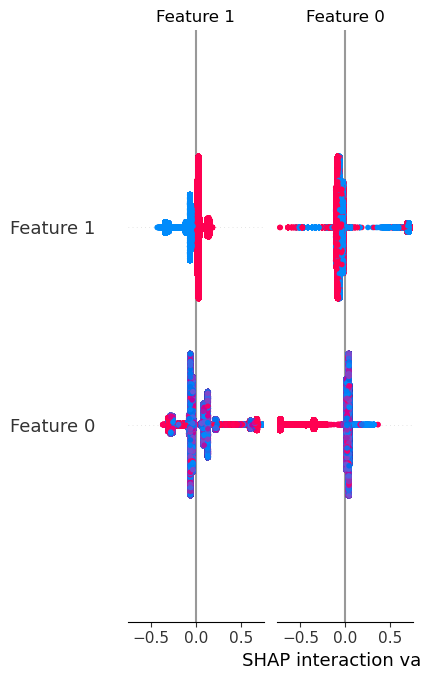

In [25]:
file_path = "cleaned_credit_data.csv"
pipeline = ModelPipeline()
dataset = pipeline.load_data(file_path)
X_train, X_test, y_train, y_test = pipeline.split_data(dataset, "fraud")
X_train, X_test, selected_features = pipeline.feature_selection(X_train, y_train, X_test, top_n=15)
X_train, X_test = pipeline.standardization(X_train, X_test)
trained_models = pipeline.train_models(X_train, y_train)
model_metrics = pipeline.evaluate_model(trained_models, X_test, y_test)
best_model = pipeline.select_best_model(model_metrics)
pipeline.error_analysis(best_model, X_test, y_test)
pipeline.save_model(best_model)
pipeline.explain_model(best_model, X_train)